In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from cnn_modelling.model import MRINet
from cnn_modelling.utils import RMSELoss, SaveBestModelMetrics
from dataset import IXIDataset
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             mean_absolute_error, mean_squared_error, r2_score)
from sklearn.model_selection import train_test_split
from tqdm import tqdm

### Configuration

In [2]:
PREPROCESSED_SCANS_DIRECTORY = r"/home/dpolak/DSC_TUTORIAL/IXI_output_stats_and_final_scans"
IXI_DEMOGRAPHIC_DATA = r"/home/dpolak/DSC_TUTORIAL/IXI.xls"
num_epochs = 50
batch_size = 4

### Loading and splitting the data into train, test and validation

In [10]:
df_main = pd.read_excel(IXI_DEMOGRAPHIC_DATA)
df_main.dropna(inplace=True, subset=("IXI_ID", "SEX_ID (1=m, 2=f)", "AGE"))

In [11]:
train_df, valid_df = train_test_split(df_main, test_size=0.2, random_state=2137, stratify=df_main["SEX_ID (1=m, 2=f)"])
valid_df, test_df = train_test_split(valid_df, test_size=0.5, random_state=2137)

In [12]:
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [13]:
train_dataloader = torch.utils.data.DataLoader(IXIDataset(train_df, PREPROCESSED_SCANS_DIRECTORY, augment=True), batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(IXIDataset(valid_df, PREPROCESSED_SCANS_DIRECTORY), batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(IXIDataset(test_df, PREPROCESSED_SCANS_DIRECTORY), batch_size=batch_size, shuffle=True)

Loaded 470 samples.
Loaded 59 samples.
Loaded 59 samples.


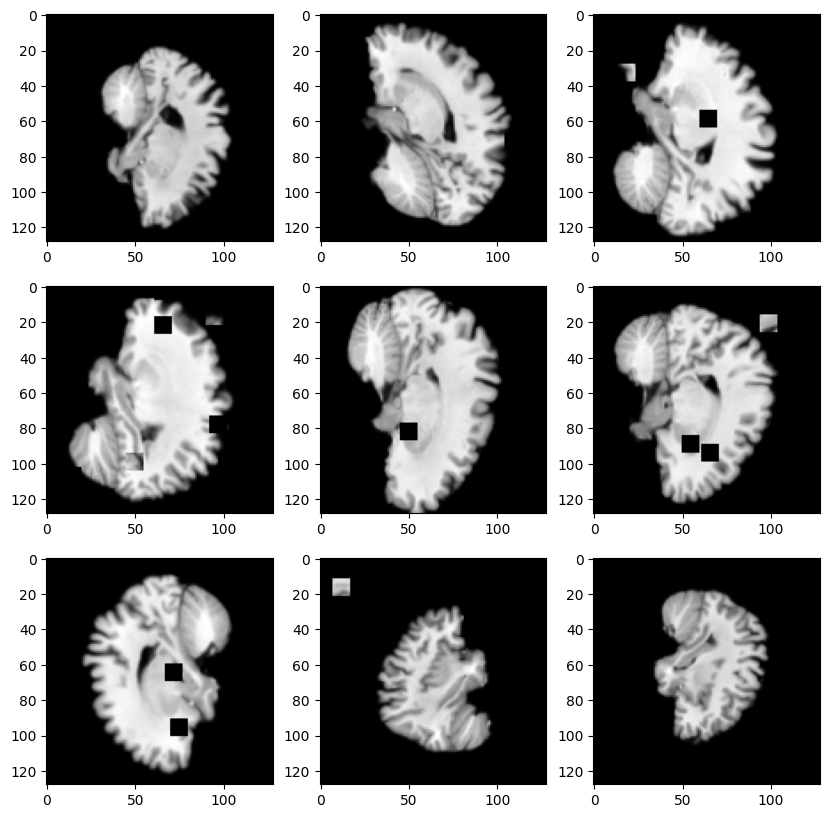

In [14]:
plt.figure(figsize=(10,10))
for i, (image, (_, __)) in enumerate(train_dataloader):
    image = image.cpu().numpy()
    plt.subplot(3, 3, i + 1)
    plt.imshow(image[0, 0, 50, :, :], cmap="gray")
    if i == 8:
        break

## Training the model

In [15]:
model = MRINet()
model = model.to("cuda")

In [16]:
class_weights = (df_main["SEX_ID (1=m, 2=f)"].value_counts().to_numpy() / len(df_main)) ** -1
print(class_weights)

[1.79878049 2.2519084 ]


In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion_ce = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights))
criterion_mse = RMSELoss()
save_best = SaveBestModelMetrics(save_path="models/pretrained")
history = {"train_loss": [], "val_loss": []}

for epoch in range(num_epochs):
    train_mse, train_ce, val_ce, val_mse, running_loss, val_running_loss = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    prbar = tqdm(train_dataloader, leave=True)
    model.train()
    step = 1
    results_sex, ground_truths_sex = [], []
    results_age, ground_truths_age = [], []
    for batch in prbar:
        inputs, (gt_age, gt_sex) = batch
        optimizer.zero_grad()
        output_age, output_sex = model(inputs)
        mse = criterion_mse(output_age.squeeze().to("cpu"), gt_age)
        ce = criterion_ce(output_sex.squeeze().to("cpu"), gt_sex) * 5
        loss = mse + ce
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_mse += mse.item()
        train_ce += ce.item()
        
        probabilities = torch.argmax(torch.softmax(output_sex, dim=1), dim=1)
        results_sex.extend(probabilities.to("cpu").detach().flatten().numpy())
        ground_truths_sex.extend(torch.argmax(gt_sex, dim=1))
        
        results_age.extend(output_age.squeeze().to("cpu").detach().numpy())
        ground_truths_age.extend(gt_age.squeeze().to("cpu").detach().numpy())
        
        accuracy = accuracy_score(ground_truths_sexce, results_sex)
        balanced_accuracy = balanced_accuracy_score(ground_truths_sex, results_sex, adjusted=False)
        r2 = r2_score(ground_truths_age, results_age)
        
        prbar.set_description(
            f"Epoch: {epoch}, "
            f"Step loss: {round(loss.item(), 3)}, "
            f"Train CE: {round(train_ce / step, 3)}, "
            f"Train RMSE: {round(train_mse / step, 3)}, "
            f"Train Accuracy: {round(accuracy, 3)}, "
            f"Train Balanced Accuracy: {round(balanced_accuracy, 3)},"
            f"Train R2: {round(r2, 3)},"
            f"Running Loss: {round(running_loss / step, 3)}"
        )
        step += 1
        history["train_loss"].append(running_loss / step)
    model.eval()

    with torch.no_grad():
        step = 1
        results_sex, ground_truths_sex = [], []
        results_age, ground_truths_age = [], []
        prbar = tqdm(valid_dataloader, leave=True)
        for batch in prbar:
            inputs, (gt_age, gt_sex) = batch
            output_age, output_sex = model(inputs)
            mse = criterion_mse(output_age.squeeze().to("cpu"), gt_age) 
            ce = criterion_ce(torch.sigmoid(output_sex).squeeze().to("cpu"), gt_sex) * 5
            probabilities = torch.argmax(torch.softmax(output_sex, dim=1), dim=1)
            
            results_sex.extend(probabilities.to("cpu").detach().flatten().numpy())
            ground_truths_sex.extend(torch.argmax(gt_sex, dim=1))
            
            results_age.extend(output_age.squeeze().to("cpu").detach().numpy())
            ground_truths_age.extend(gt_age.squeeze().to("cpu").detach().numpy())
            
            accuracy = accuracy_score(ground_truths_sex, results_sex)
            balanced_accuracy = balanced_accuracy_score(ground_truths_sex, results_sex, adjusted=False)
            r2 = r2_score(ground_truths_age, results_age)
            
            val_mse += mse.item()
            val_ce += ce.item()
            loss = ce + mse
            val_running_loss += loss.item()
            
            prbar.set_description(
                f"Validation epoch: {epoch}, Step loss: {round(loss.item(), 3)}, "
                f"Valid CE: {round(val_ce / step, 3)}, "
                f"Valid RMSE: {round(val_mse / step, 3)}, "
                f"Valid Accuracy: {round(accuracy, 3)}, "
                f"Valid Balanced Accuracy: {round(balanced_accuracy, 3)},"
                f"Valid R2: {round(r2, 3)},"
                f"Running Loss: {round(val_running_loss / step, 3)}"
            )
            
            step += 1
        history["val_loss"].append(val_running_loss / step)
    save_best(balanced_accuracy + r2, epoch, model)

Epoch: 0, Step loss: 48.948, Train CE: 8.677, Train RMSE: 46.701, Train Accuracy: 0.517, Train Balanced Accuracy: 0.498,Train R2: -7.23,Running Loss: 55.378: 100%|██████████| 118/118 [00:49<00:00,  2.38it/s] 
Validation epoch: 0, Step loss: 61.648, Valid CE: 6.964, Valid RMSE: 45.012, Valid Accuracy: 0.593, Valid Balanced Accuracy: 0.558,Valid R2: -6.677,Running Loss: 51.976: 100%|██████████| 15/15 [00:03<00:00,  4.44it/s]



Best validation metric: -6.118933055817436

Saving best model for epoch: 1


Epoch: 1, Step loss: 40.951, Train CE: 8.31, Train RMSE: 30.574, Train Accuracy: 0.545, Train Balanced Accuracy: 0.526,Train R2: -2.772,Running Loss: 38.884: 100%|██████████| 118/118 [00:46<00:00,  2.55it/s] 
Validation epoch: 1, Step loss: 43.728, Valid CE: 7.012, Valid RMSE: 25.511, Valid Accuracy: 0.559, Valid Balanced Accuracy: 0.519,Valid R2: -1.485,Running Loss: 32.523: 100%|██████████| 15/15 [00:03<00:00,  4.19it/s]



Best validation metric: -0.9661971001830844

Saving best model for epoch: 2


Epoch: 2, Step loss: 24.969, Train CE: 9.547, Train RMSE: 16.652, Train Accuracy: 0.513, Train Balanced Accuracy: 0.495,Train R2: -0.128,Running Loss: 26.199: 100%|██████████| 118/118 [00:47<00:00,  2.50it/s]
  0%|          | 0/15 [00:00<?, ?it/s]/home/dpolak/miniconda3/envs/CV/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Validation epoch: 2, Step loss: 20.061, Valid CE: 7.07, Valid RMSE: 14.094, Valid Accuracy: 0.576, Valid Balanced Accuracy: 0.537,Valid R2: 0.216,Running Loss: 21.164: 100%|██████████| 15/15 [00:03<00:00,  4.21it/s] 



Best validation metric: 0.7528115926928336

Saving best model for epoch: 3


Epoch: 3, Step loss: 39.433, Train CE: 9.151, Train RMSE: 15.107, Train Accuracy: 0.545, Train Balanced Accuracy: 0.525,Train R2: 0.108,Running Loss: 24.258: 100%|██████████| 118/118 [00:47<00:00,  2.49it/s] 
Validation epoch: 3, Step loss: 18.031, Valid CE: 7.083, Valid RMSE: 15.843, Valid Accuracy: 0.458, Valid Balanced Accuracy: 0.497,Valid R2: -0.01,Running Loss: 22.926: 100%|██████████| 15/15 [00:03<00:00,  4.15it/s] 
Epoch: 4, Step loss: 8.358, Train CE: 8.79, Train RMSE: 14.252, Train Accuracy: 0.521, Train Balanced Accuracy: 0.504,Train R2: 0.184,Running Loss: 23.041: 100%|██████████| 118/118 [00:47<00:00,  2.50it/s]  
Validation epoch: 4, Step loss: 26.092, Valid CE: 7.049, Valid RMSE: 12.996, Valid Accuracy: 0.542, Valid Balanced Accuracy: 0.5,Valid R2: 0.331,Running Loss: 20.046: 100%|██████████| 15/15 [00:03<00:00,  4.11it/s]



Best validation metric: 0.8307839897980865

Saving best model for epoch: 5


Epoch: 5, Step loss: 28.149, Train CE: 8.127, Train RMSE: 13.966, Train Accuracy: 0.568, Train Balanced Accuracy: 0.546,Train R2: 0.235,Running Loss: 22.093: 100%|██████████| 118/118 [00:46<00:00,  2.54it/s]
Validation epoch: 5, Step loss: 28.317, Valid CE: 7.064, Valid RMSE: 12.256, Valid Accuracy: 0.576, Valid Balanced Accuracy: 0.569,Valid R2: 0.395,Running Loss: 19.32: 100%|██████████| 15/15 [00:03<00:00,  4.03it/s] 



Best validation metric: 0.9634752877608115

Saving best model for epoch: 6


Epoch: 6, Step loss: 29.247, Train CE: 8.136, Train RMSE: 13.625, Train Accuracy: 0.553, Train Balanced Accuracy: 0.537,Train R2: 0.257,Running Loss: 21.762: 100%|██████████| 118/118 [00:46<00:00,  2.51it/s]
Validation epoch: 6, Step loss: 29.01, Valid CE: 7.069, Valid RMSE: 11.874, Valid Accuracy: 0.627, Valid Balanced Accuracy: 0.601,Valid R2: 0.419,Running Loss: 18.942: 100%|██████████| 15/15 [00:03<00:00,  4.31it/s] 



Best validation metric: 1.0199533186817202

Saving best model for epoch: 7


Epoch: 7, Step loss: 16.361, Train CE: 8.371, Train RMSE: 13.548, Train Accuracy: 0.534, Train Balanced Accuracy: 0.513,Train R2: 0.258,Running Loss: 21.92: 100%|██████████| 118/118 [00:45<00:00,  2.59it/s] 
Validation epoch: 7, Step loss: 18.544, Valid CE: 7.051, Valid RMSE: 10.349, Valid Accuracy: 0.559, Valid Balanced Accuracy: 0.533,Valid R2: 0.552,Running Loss: 17.4: 100%|██████████| 15/15 [00:03<00:00,  4.32it/s]  



Best validation metric: 1.0851376001536577

Saving best model for epoch: 8


Epoch: 8, Step loss: 8.869, Train CE: 7.721, Train RMSE: 12.699, Train Accuracy: 0.572, Train Balanced Accuracy: 0.552,Train R2: 0.337,Running Loss: 20.42: 100%|██████████| 118/118 [00:44<00:00,  2.63it/s]  
Validation epoch: 8, Step loss: 31.3, Valid CE: 7.013, Valid RMSE: 20.208, Valid Accuracy: 0.559, Valid Balanced Accuracy: 0.521,Valid R2: -0.587,Running Loss: 27.221: 100%|██████████| 15/15 [00:03<00:00,  4.36it/s]  
Epoch: 9, Step loss: 14.735, Train CE: 8.081, Train RMSE: 13.031, Train Accuracy: 0.555, Train Balanced Accuracy: 0.532,Train R2: 0.304,Running Loss: 21.111: 100%|██████████| 118/118 [00:45<00:00,  2.59it/s]
Validation epoch: 9, Step loss: 20.767, Valid CE: 7.066, Valid RMSE: 11.814, Valid Accuracy: 0.627, Valid Balanced Accuracy: 0.61,Valid R2: 0.438,Running Loss: 18.88: 100%|██████████| 15/15 [00:03<00:00,  4.33it/s]  
Epoch: 10, Step loss: 21.662, Train CE: 8.193, Train RMSE: 12.885, Train Accuracy: 0.553, Train Balanced Accuracy: 0.53,Train R2: 0.33,Running Loss: 


Best validation metric: 1.1611014585660078

Saving best model for epoch: 11


Epoch: 11, Step loss: 19.957, Train CE: 7.882, Train RMSE: 12.777, Train Accuracy: 0.566, Train Balanced Accuracy: 0.544,Train R2: 0.343,Running Loss: 20.659: 100%|██████████| 118/118 [00:45<00:00,  2.59it/s]
Validation epoch: 11, Step loss: 38.84, Valid CE: 7.026, Valid RMSE: 26.135, Valid Accuracy: 0.61, Valid Balanced Accuracy: 0.574,Valid R2: -1.61,Running Loss: 33.16: 100%|██████████| 15/15 [00:03<00:00,  4.39it/s]    
Epoch: 12, Step loss: 5.726, Train CE: 7.619, Train RMSE: 12.854, Train Accuracy: 0.543, Train Balanced Accuracy: 0.52,Train R2: 0.328,Running Loss: 20.474: 100%|██████████| 118/118 [00:45<00:00,  2.59it/s]  
Validation epoch: 12, Step loss: 17.328, Valid CE: 7.003, Valid RMSE: 15.478, Valid Accuracy: 0.627, Valid Balanced Accuracy: 0.593,Valid R2: 0.029,Running Loss: 22.481: 100%|██████████| 15/15 [00:03<00:00,  4.35it/s] 
Epoch: 13, Step loss: 45.27, Train CE: 7.344, Train RMSE: 12.8, Train Accuracy: 0.596, Train Balanced Accuracy: 0.573,Train R2: 0.329,Running Lo


Best validation metric: 1.173470198948551

Saving best model for epoch: 18


Epoch: 18, Step loss: 20.536, Train CE: 7.635, Train RMSE: 12.263, Train Accuracy: 0.566, Train Balanced Accuracy: 0.544,Train R2: 0.368,Running Loss: 19.898: 100%|██████████| 118/118 [00:45<00:00,  2.59it/s]
Validation epoch: 18, Step loss: 19.248, Valid CE: 7.039, Valid RMSE: 12.531, Valid Accuracy: 0.712, Valid Balanced Accuracy: 0.711,Valid R2: 0.376,Running Loss: 19.57: 100%|██████████| 15/15 [00:03<00:00,  4.31it/s] 
Epoch: 19, Step loss: 23.501, Train CE: 7.01, Train RMSE: 11.626, Train Accuracy: 0.606, Train Balanced Accuracy: 0.585,Train R2: 0.448,Running Loss: 18.636: 100%|██████████| 118/118 [00:45<00:00,  2.58it/s] 
Validation epoch: 19, Step loss: 18.902, Valid CE: 7.02, Valid RMSE: 13.746, Valid Accuracy: 0.576, Valid Balanced Accuracy: 0.543,Valid R2: 0.218,Running Loss: 20.766: 100%|██████████| 15/15 [00:03<00:00,  4.32it/s] 
Epoch: 20, Step loss: 17.221, Train CE: 7.165, Train RMSE: 12.054, Train Accuracy: 0.579, Train Balanced Accuracy: 0.556,Train R2: 0.392,Running L


Best validation metric: 1.224989009069286

Saving best model for epoch: 23


Epoch: 23, Step loss: 10.98, Train CE: 6.913, Train RMSE: 11.709, Train Accuracy: 0.609, Train Balanced Accuracy: 0.584,Train R2: 0.433,Running Loss: 18.622: 100%|██████████| 118/118 [00:46<00:00,  2.56it/s] 
Validation epoch: 23, Step loss: 16.564, Valid CE: 7.041, Valid RMSE: 9.452, Valid Accuracy: 0.678, Valid Balanced Accuracy: 0.66,Valid R2: 0.635,Running Loss: 16.494: 100%|██████████| 15/15 [00:03<00:00,  4.44it/s] 



Best validation metric: 1.2951736302221541

Saving best model for epoch: 24


Epoch: 24, Step loss: 28.052, Train CE: 6.916, Train RMSE: 11.627, Train Accuracy: 0.598, Train Balanced Accuracy: 0.576,Train R2: 0.444,Running Loss: 18.543: 100%|██████████| 118/118 [00:46<00:00,  2.54it/s]
Validation epoch: 24, Step loss: 24.009, Valid CE: 6.997, Valid RMSE: 14.75, Valid Accuracy: 0.644, Valid Balanced Accuracy: 0.623,Valid R2: 0.147,Running Loss: 21.747: 100%|██████████| 15/15 [00:03<00:00,  4.42it/s] 
  0%|          | 0/118 [00:00<?, ?it/s]/home/dpolak/miniconda3/envs/CV/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Epoch: 25, Step loss: 20.685, Train CE: 7.016, Train RMSE: 12.089, Train Accuracy: 0.574, Train Balanced Accuracy: 0.55,Train R2: 0.396,Running Loss: 19.105: 100%|██████████| 118/118 [00:45<00:00,  2.61it/s] 
Validation epoch: 25, Step loss: 13.914, Valid CE: 7.029, Valid RMSE: 8.997, Valid Accuracy: 0.576, Valid Balanced 


Best validation metric: 1.3318982668723864

Saving best model for epoch: 30


Epoch: 30, Step loss: 13.694, Train CE: 6.571, Train RMSE: 11.673, Train Accuracy: 0.623, Train Balanced Accuracy: 0.603,Train R2: 0.421,Running Loss: 18.244: 100%|██████████| 118/118 [00:45<00:00,  2.59it/s]
Validation epoch: 30, Step loss: 14.237, Valid CE: 7.002, Valid RMSE: 8.311, Valid Accuracy: 0.746, Valid Balanced Accuracy: 0.734,Valid R2: 0.703,Running Loss: 15.313: 100%|██████████| 15/15 [00:03<00:00,  4.46it/s]



Best validation metric: 1.4364434143519027

Saving best model for epoch: 31


Epoch: 31, Step loss: 9.745, Train CE: 6.842, Train RMSE: 11.649, Train Accuracy: 0.609, Train Balanced Accuracy: 0.586,Train R2: 0.437,Running Loss: 18.491: 100%|██████████| 118/118 [00:45<00:00,  2.58it/s] 
Validation epoch: 31, Step loss: 17.553, Valid CE: 6.996, Valid RMSE: 8.428, Valid Accuracy: 0.644, Valid Balanced Accuracy: 0.631,Valid R2: 0.709,Running Loss: 15.424: 100%|██████████| 15/15 [00:03<00:00,  4.43it/s]
Epoch: 32, Step loss: 23.721, Train CE: 6.257, Train RMSE: 11.809, Train Accuracy: 0.638, Train Balanced Accuracy: 0.618,Train R2: 0.434,Running Loss: 18.066: 100%|██████████| 118/118 [00:45<00:00,  2.62it/s]
Validation epoch: 32, Step loss: 11.533, Valid CE: 6.911, Valid RMSE: 13.981, Valid Accuracy: 0.695, Valid Balanced Accuracy: 0.675,Valid R2: 0.144,Running Loss: 20.892: 100%|██████████| 15/15 [00:03<00:00,  4.32it/s]
  0%|          | 0/118 [00:00<?, ?it/s]/home/dpolak/miniconda3/envs/CV/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWa


Best validation metric: 1.4446564219719513

Saving best model for epoch: 40


Epoch: 40, Step loss: 22.684, Train CE: 6.481, Train RMSE: 11.894, Train Accuracy: 0.619, Train Balanced Accuracy: 0.598,Train R2: 0.418,Running Loss: 18.375: 100%|██████████| 118/118 [00:45<00:00,  2.57it/s]
Validation epoch: 40, Step loss: 13.367, Valid CE: 7.009, Valid RMSE: 8.146, Valid Accuracy: 0.712, Valid Balanced Accuracy: 0.7,Valid R2: 0.712,Running Loss: 15.155: 100%|██████████| 15/15 [00:03<00:00,  4.26it/s] 
Epoch: 41, Step loss: 18.098, Train CE: 6.398, Train RMSE: 11.122, Train Accuracy: 0.636, Train Balanced Accuracy: 0.612,Train R2: 0.486,Running Loss: 17.52: 100%|██████████| 118/118 [00:44<00:00,  2.63it/s] 
Validation epoch: 41, Step loss: 20.747, Valid CE: 7.044, Valid RMSE: 14.359, Valid Accuracy: 0.644, Valid Balanced Accuracy: 0.626,Valid R2: 0.202,Running Loss: 21.402: 100%|██████████| 15/15 [00:03<00:00,  4.38it/s]
Epoch: 42, Step loss: 24.996, Train CE: 6.209, Train RMSE: 11.575, Train Accuracy: 0.685, Train Balanced Accuracy: 0.668,Train R2: 0.441,Running Los

### Evaluation on the test set

In [17]:
model.load_state_dict(torch.load(f"/home/dpolak/dsc-2023-mri-classification/cnn_modelling/models/pretrained/best_model.pth"))
model.eval()
test_results_age = []
test_ground_truths_age = []
test_results_sex = []
test_ground_truths_sex = []
for test_batch in test_dataloader:
    output_age, output_sex = model.forward(test_batch[0])
    test_results_age.extend(output_age.squeeze().to("cpu").detach().numpy())
    test_ground_truths_age.extend(test_batch[1][0].squeeze().to("cpu").detach().numpy())
    test_results_sex.extend(torch.argmax(torch.softmax(output_sex, dim=1), dim=1).to("cpu").detach().numpy())
    test_ground_truths_sex.extend(torch.argmax(test_batch[1][1], dim=1))
    
test_accuracy = accuracy_score(test_ground_truths_sex, test_results_sex, normalize=True)
test_balanced_accuracy = balanced_accuracy_score(test_ground_truths_sex, test_results_sex,  adjusted=False)
test_mse = mean_squared_error(test_ground_truths_age, test_results_age)
test_mae = mean_absolute_error(test_ground_truths_age, test_results_age)
test_r2 = r2_score(test_ground_truths_age, test_results_age)
print(f"Test Accuracy: {round(test_accuracy, 3)}")
print(f"Test Balanced Accuracy: {round(test_balanced_accuracy, 3)}")
print(f"Test MSE: {round(test_mse, 3)}")
print(f"Test MAE: {round(test_mae, 3)}")
print(f"Test R2: {round(test_r2, 3)}")

Test Accuracy: 0.814
Test Balanced Accuracy: 0.806
Test MSE: 71.3270034790039
Test MAE: 7.021999835968018
Test R2: 0.768


In [18]:
np.concatenate((np.array(test_results_age).reshape(-1, 1), np.array(test_ground_truths_age).reshape(-1, 1)), axis=1)

array([[26.963243, 26.579056],
       [28.447767, 26.272417],
       [68.35996 , 63.41684 ],
       [73.374214, 72.09035 ],
       [33.26544 , 28.24367 ],
       [61.64385 , 58.28063 ],
       [28.437258, 25.938398],
       [30.817541, 34.01232 ],
       [38.054226, 31.59206 ],
       [33.517494, 20.16701 ],
       [58.818916, 61.99589 ],
       [28.448757, 27.014374],
       [52.50899 , 58.78166 ],
       [46.36042 , 44.093086],
       [63.394333, 72.1451  ],
       [72.993645, 68.481865],
       [44.48752 , 56.963722],
       [69.86542 , 74.01232 ],
       [41.696476, 31.849419],
       [58.70135 , 64.66256 ],
       [68.17444 , 59.471596],
       [46.25164 , 55.827515],
       [43.633656, 48.05202 ],
       [31.349741, 26.984257],
       [62.220715, 69.067764],
       [61.408546, 66.275154],
       [39.83514 , 24.895277],
       [31.62322 , 25.18549 ],
       [59.246334, 67.53457 ],
       [46.786625, 41.059547],
       [36.3606  , 22.570843],
       [57.87295 , 63.540043],
       [

In [19]:
np.concatenate((np.array(test_results_sex).reshape(-1,1), np.array(test_ground_truths_sex).reshape(-1,1)), axis=1)

array([[0, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 1],
       [0, 0],
       [1, 1],
       [0, 1],
       [1, 1],
       [0, 0],
       [1, 0],
       [0, 0],
       [1, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 0],
       [0, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 0],
       [1, 1],
       [1, 1],
       [1, 0],
       [1, 1],
       [1, 1],
       [1, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1]])